# DeepFM

## 0. Imports

In [25]:
# Basic Data Analysis Tools
import numpy as np
import pandas as pd
from os.path import exists
import itertools
from ast import literal_eval
import matplotlib.pyplot as plt

# Keras imports for deepFM, 1st & 2nd order FM: all of which can be implemented as neural networks
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Hyperparameter tunning
import talos
from talos.utils.gpu_utils import parallel_gpu_jobs

In [2]:
predict_only_new_products = False
prod_class="variation"

In [3]:
def transaction_preprocess(transactions, train_bounds, test_bounds, prod_class="variation", time_period = 125):
    """
    args:
        transactions: pd.DataFrame -> the transaction_history.csv provided by Siemens
        train_bounds, test_bounds: (lower: int, upper: int) -> bounds for splitting dataset into train and test based on "day" feature
        time_period: map day feature into month, years, etc. (default 125 days = 4 months)
    returns:
        transactions: pd.DataFrame -> processed dataframe with encoded categories and mapped days
        train_rnd_sample: pd.DataFrame -> all positive samples within train as well as an equal number of randomly sampled negative samples
        test_rnd_sample: pd.DataFrame -> 
    """
    transactions = transactions.copy() 
    
    # encode categorical variables
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    # FOR TESTING PURPOSES: I dont have much RAM :)
    transactions = transactions[(transactions["customer"] < 100)]
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    transactions["day"] = transactions["day"] // time_period # map days to weeks, months, years
    if prod_class == "product":
        transactions["prod"] = transactions["prod"].str.split("_").apply(lambda x: x[0].join(x[1]))
    elif prod_class == "family":
        transactions["prod"] = transactions["prod"].str.split("_").apply(lambda x: x[0])
    
    transactions["prod"] = transactions["prod"].astype('category').cat.codes 
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    
    # set labels to 1 - all products present were bought
    transactions["label"] = 1
    
    # create product customer list
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    # drop rows with missing values
    transaction = transactions.dropna()
    
    # create train & test set
    train = transactions[(transaction.day >= train_bounds[0] // time_period) & (transactions.day < train_bounds[1] // time_period)]
    test = transactions[(transaction.day >= test_bounds[0] // time_period) & (transactions.day < test_bounds[1] // time_period)]
    print(len(test))
    
    # get unique customer and product lists
    customers = transactions["customer"].unique()
    products = train["prod"].unique() # transactions["prod"].unique() # use products only from train to make sure
    train_products_set = set(products)
    train_customers_set = set(customers)
    
    # Remove missing from test products
    print(f"LEN {len(test)}")
    test = test[test["prod"].apply(lambda x: x in train_products_set)]
    print(len(test))
    test = test[test["customer"].apply(lambda x: x in train_customers_set)]
    print(len(test))
    
    # set of day-customer-bought product for negative sampling
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    # get days and customers
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"], test["prod"]))
    
    prod_list = set(products) 
    test_customer_prod_day = set([tuple(r) for r in test[["day", "customer", "prod"]].to_numpy()]) # Set of positive test_days x customer x prod
    all_test_customer_prod_day = set([x for x in itertools.product(test_days, customers, products)]) # Set of all test_days x customer x prod
    neg_test_customer_prod_day = all_test_customer_prod_day - test_customer_prod_day # Set of negative test_days x customer x prod
    
    # Create test dataset
    final_neg_sampl = test[["customer", "domestic", "state",
                            "ind_code", "ind_seg_code"]].drop_duplicates() # customer info - customer_id unique identifier of customer
    final_neg_sampl = final_neg_sampl.merge(pd.DataFrame(neg_test_customer_prod_day, columns=["day", "customer", "prod"]), how="inner", on="customer") # cartezian product of product, customer, day and customer info
    final_neg_sampl["label"] = 0 # set all products as unbought (non-sampled)
    test["label"] = 1 # set all products present in test as positive
    final_neg_sampl = final_neg_sampl.append(test.drop(["new_orders", "prod_customer"],axis=1)) # join positive and negative
    final_neg_sampl = final_neg_sampl.drop_duplicates()

    
    # specify train sample size (c)
    SAMPLE_SIZE = int(np.ceil(1.0 * len(train))) # Set negative train size
    train_days = train["day"].unique()
    
    # Bootstrap negative sample train set (only samples from train set were used) - in case no bootstraping is desired change replace -> False
    # Removes potential outliers which have for example bought only one item or that are highly unlikely to buy an item
    train_rnd_sample = np.array([np.random.choice(train_days, size=SAMPLE_SIZE),\
                                              np.random.choice(customers, size=SAMPLE_SIZE),\
                                              np.random.choice(products, size=SAMPLE_SIZE)]).T
    
    # remove samples that were actually bought (are in hit_combo)
    not_faulty = [tuple(train_rnd_sample[row,:]) not in hit_combo for row in range(train_rnd_sample.shape[0])]
    train_rnd_sample = train_rnd_sample[not_faulty]
    
    # Drop duplicated rows
    train_rnd_sample = pd.DataFrame(train_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    
    # Add customer info - uniquely defined by customer_id
    train_rnd_sample = train_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    train_rnd_sample["label"] = 0 # Set negative labels
    
    # Merge positive and negative train samples
    train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    return transactions, train_rnd_sample.sample(frac=1).reset_index(drop=True), final_neg_sampl, products, customers


In [29]:
transactions = pd.read_csv("dataset/transaction_history.csv") # load dataset
transformations = [] # includes train, test folds for CV

for i in range(1):
    print(f"Iteration {i}", end="\r")
    transformed, train, test, products, customers = transaction_preprocess(transactions, (i*125, (i+4)*125), ((i+4)*125, (i+5)*125), prod_class="variation") 
    print(test.drop_duplicates().label.sum())
    transformations.append((train, test))
train, test = transformations[0]

2195ation 0
LEN 2195
2063
2063
1078


In [5]:
len(test)

84189

## 1. Models

### 1.1 Model parts

In [30]:
def define_input_layers(df):
    """
    Defines input layers for all ML models used in this notebook.
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    day_input = Input((1,), name = 'day')
    num_inputs = [day_input] # continuous numeric inputs
    cat_input = [Input((1,), name= col) for col in ['customer', 'prod', 'state', 'ind_code',
       'ind_seg_code', 'domestic']] # discrete categorical inputs
    cat_sl_inputs = [cat_input] 

    inputs = num_inputs + cat_sl_inputs # join inputs
    
    return inputs

inputs = define_input_layers(transformed)

In [31]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

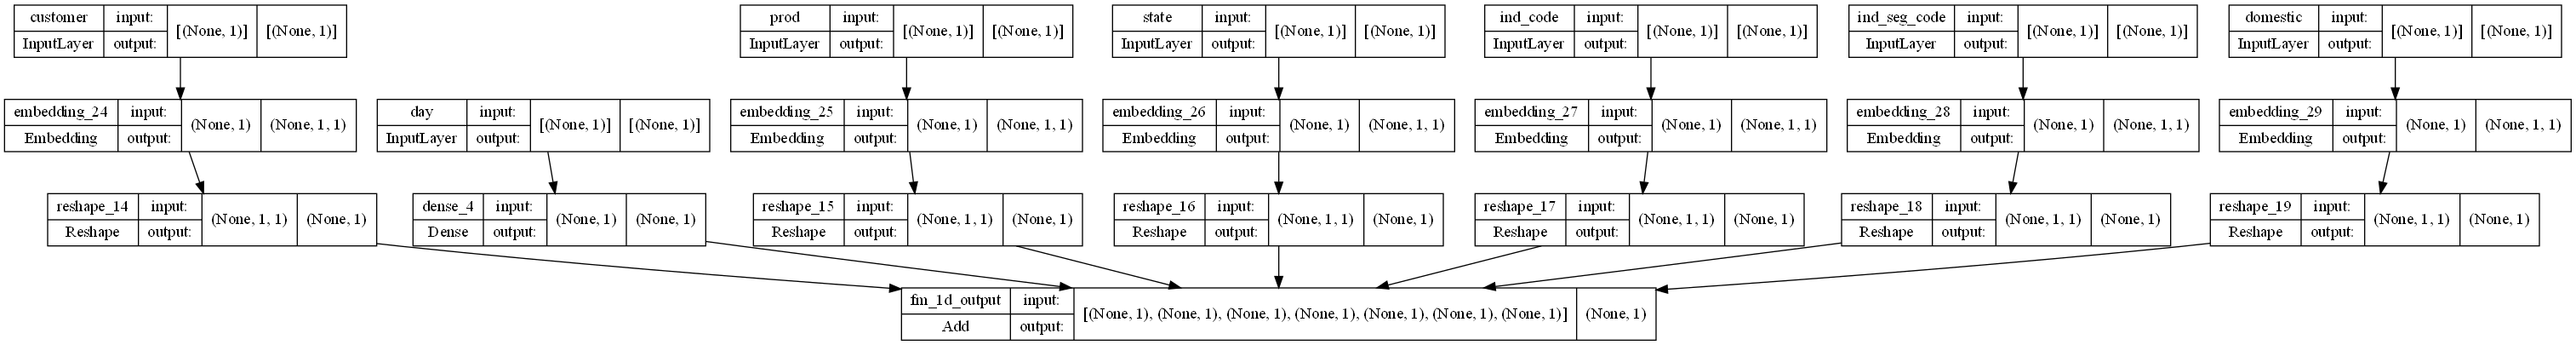

In [32]:
def fm_1d(inputs):
    """
    1st order FM output = sum a_i * f_i, linear combination of features
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    num_inputs, cat_inputs = inputs 
    
    # all tensors are reshape to (None, 1)
    num_dense_1d  = [Dense(1)(num_inputs)]
    
    cat_sl_embed_1d = [Embedding(transformed[inpt.name].nunique() + 1, 1)(inpt) for inpt in cat_inputs]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d)
    return y_fm_1d

y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
plot_model(fm_model_1d, show_shapes=True, show_layer_names=True)

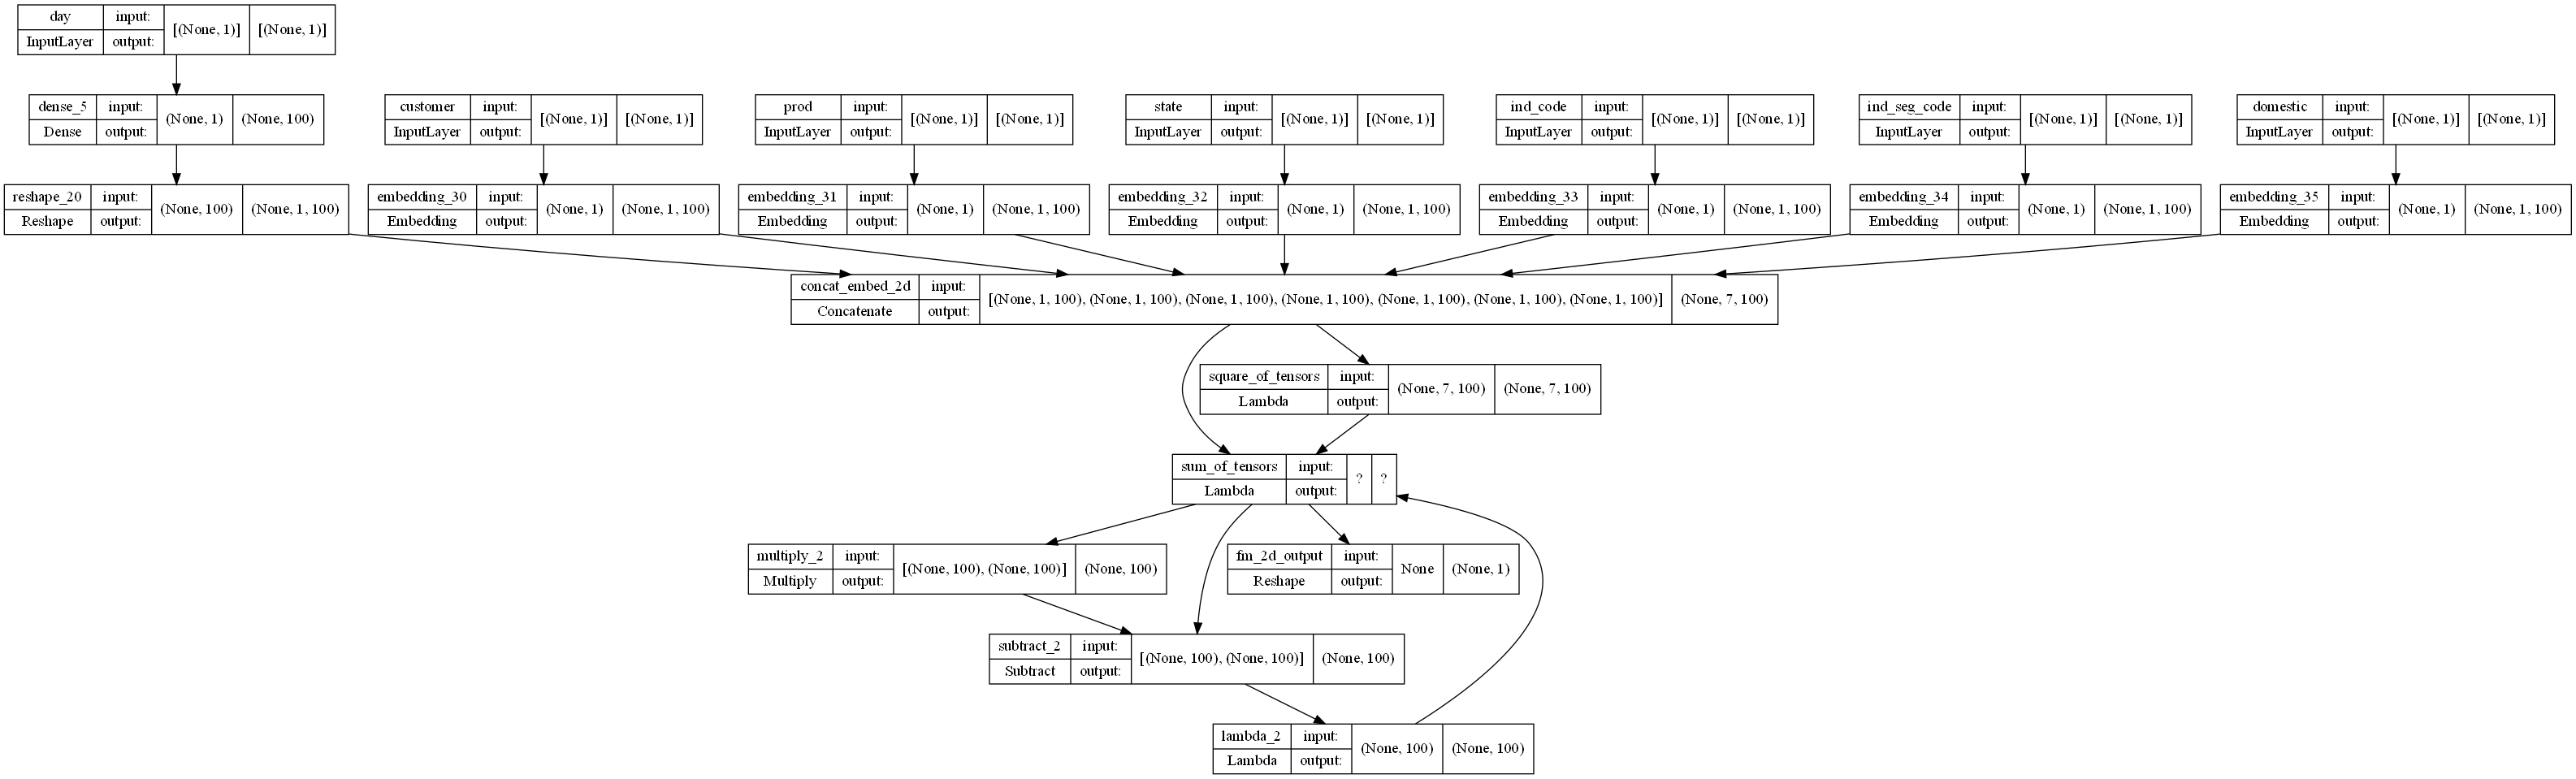

In [33]:
def fm_2d(inputs, k):
    num_inputs, cat_inputs = inputs
    
    num_dense_2d = [Dense(k)(num_inputs)]
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d]
    
    cat_sl_embed_2d = [Embedding(transformed[inpt.name].nunique() + 1, k)(inpt) for inpt in cat_inputs]
    
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d)
    
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d
    
y_2d, embed_2d = fm_2d(inputs, 100)
fm_model_2d = Model(inputs, y_2d)
plot_model(fm_model_2d, show_shapes=True, show_layer_names=True)

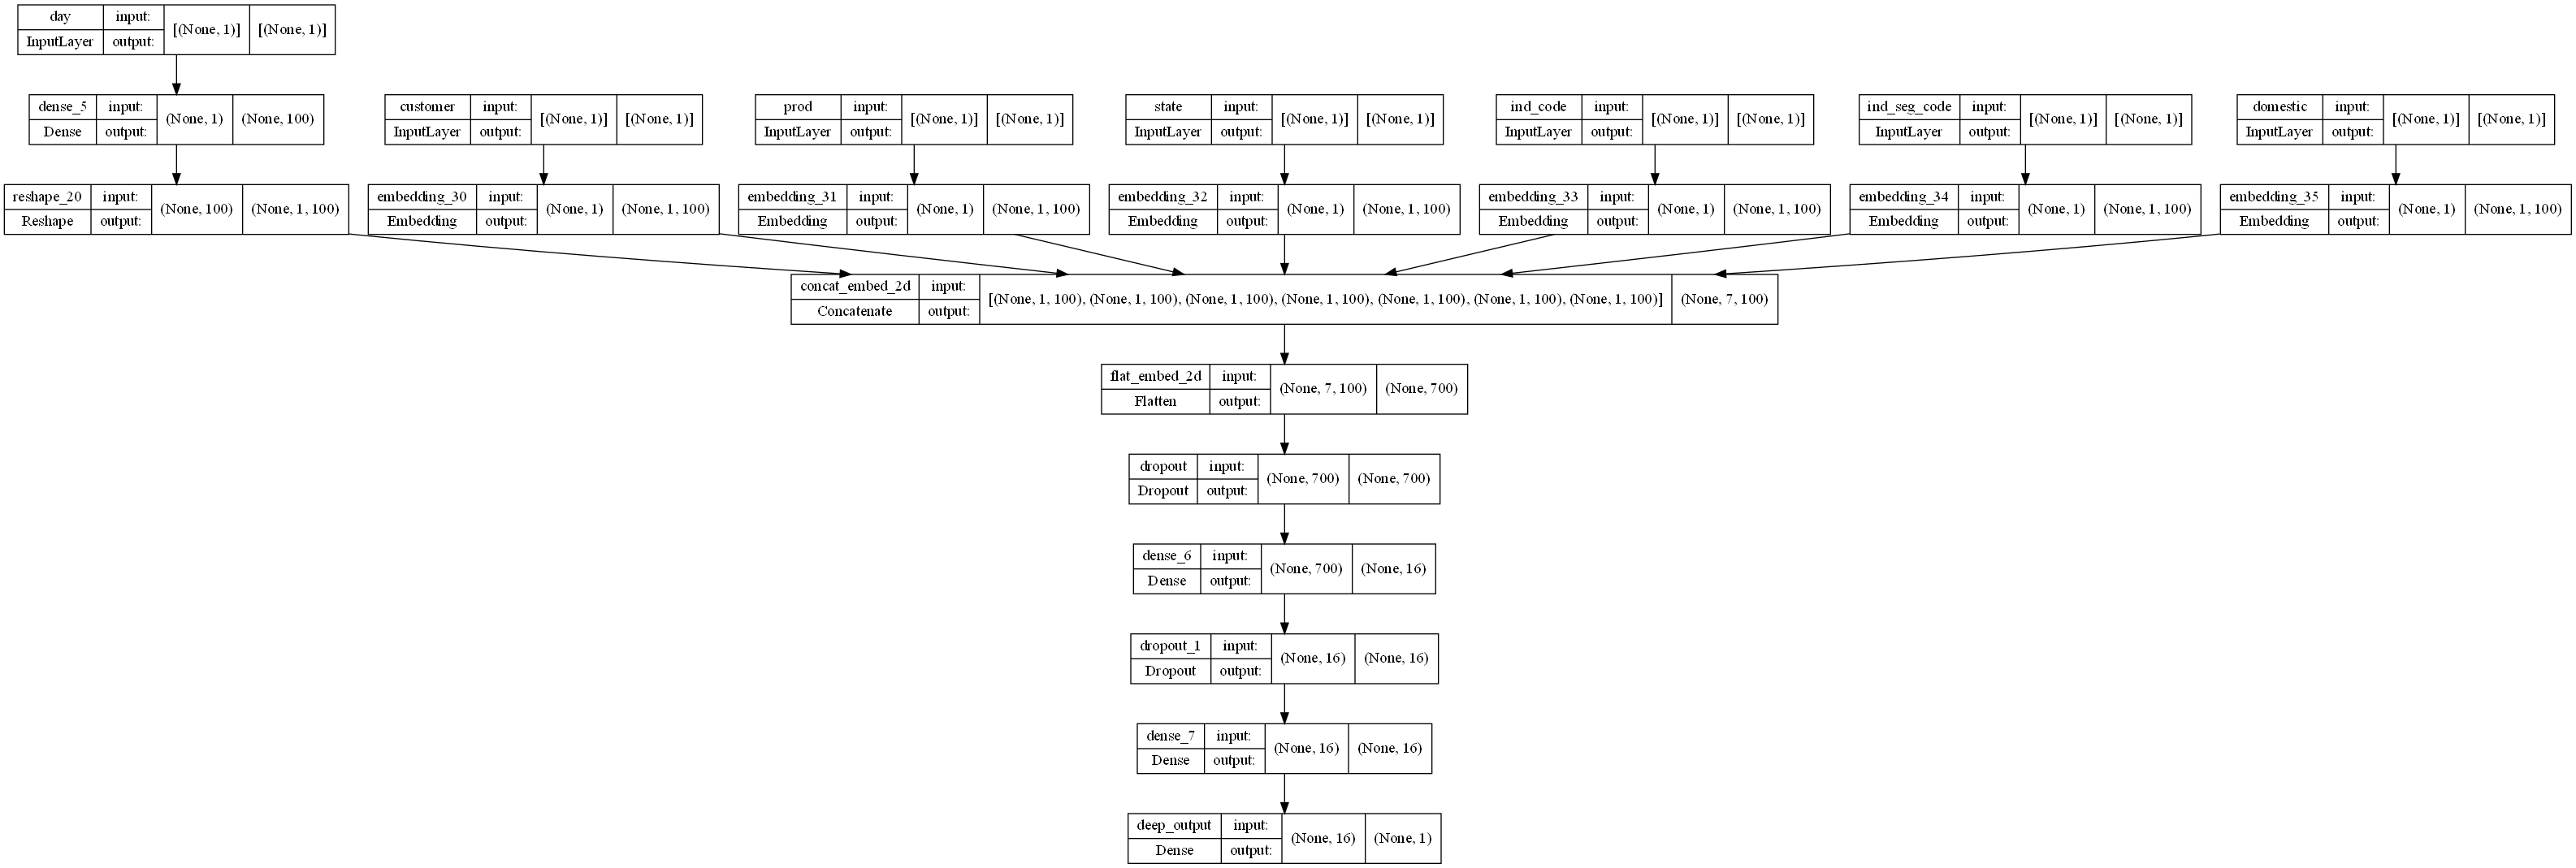

In [34]:
def dnn_part(embed_2d, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu"):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation=act_fun,
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn)
    y_dnn = Dense(1, activation=act_fun, name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = dnn_part(embed_2d, [16, 16], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'deep_output')>]


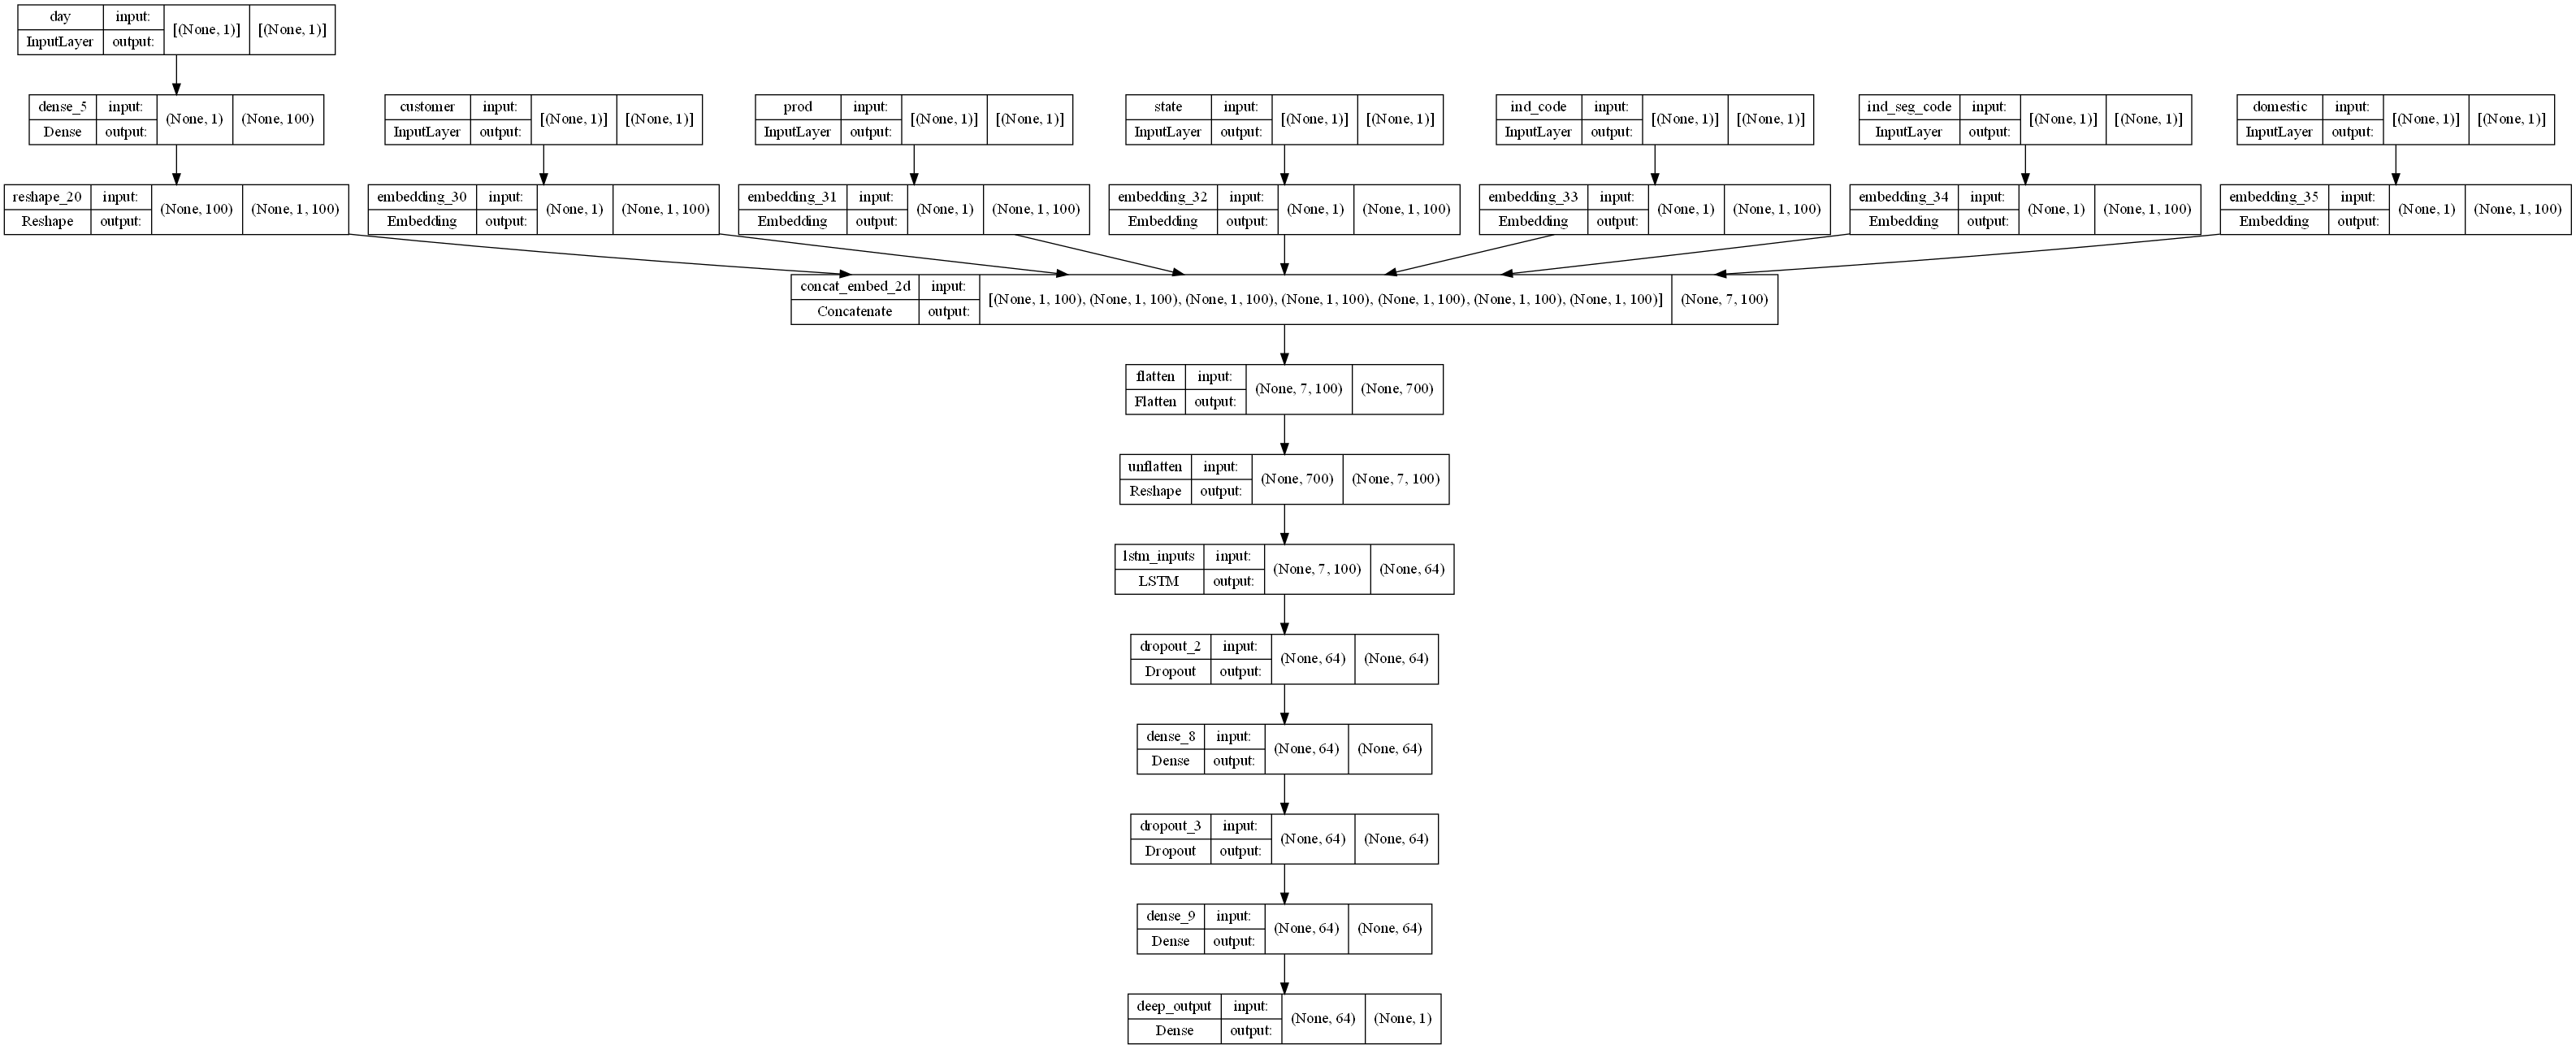

In [35]:
def lstm_part(embed_2d, lstm_dim, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    num_inputs, cat_inputs = inputs
    
    # flat embed layers from 3D to 2D tensors
    # flatten and unflatten (needed for concetanation)
    y_dnn = Flatten(name = 'flatten')(embed_2d)
    y_dnn = Reshape(embed_2d.shape[1:], name = "unflatten")(y_dnn)

    y_dnn = LSTM(lstm_dim[0], activation=lstm_fun, return_sequences=False, name="lstm_inputs",
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn) # Flatten(name = 'flat_embed_2d')(embed_2d)
    
    # print("Got to here!")
    # for h in lstm_dim[1:-1]:
    #    print("Got to here!")
    #    y_dnn = LSTM(h, return_sequences=True, activation='tanh',
    #                  kernel_regularizer=regularizers.L1(l1),
    #                  activity_regularizer=regularizers.L2(l2))(y_dnn)
    #    y_dnn = Dropout(dnn_dr)(y_dnn)
    
    #if len(lstm_dim) > 1:
    #    y_dnn = LSTM(lstm_dim[-1], return_sequences=False, activation='tanh', name="lstm_outputs",
    #                  kernel_regularizer=regularizers.L1(l1),
    #                  activity_regularizer=regularizers.L2(l2))(y_dnn)
    #    y_dnn = Dropout(dnn_dr)(y_dnn)
    
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation=act_fun,
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn)
    y_dnn = Dense(1, activation=act_fun, name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = lstm_part(embed_2d, [64], [64, 64], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
print(fm_model_dnn.outputs)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

### 1.2 Models

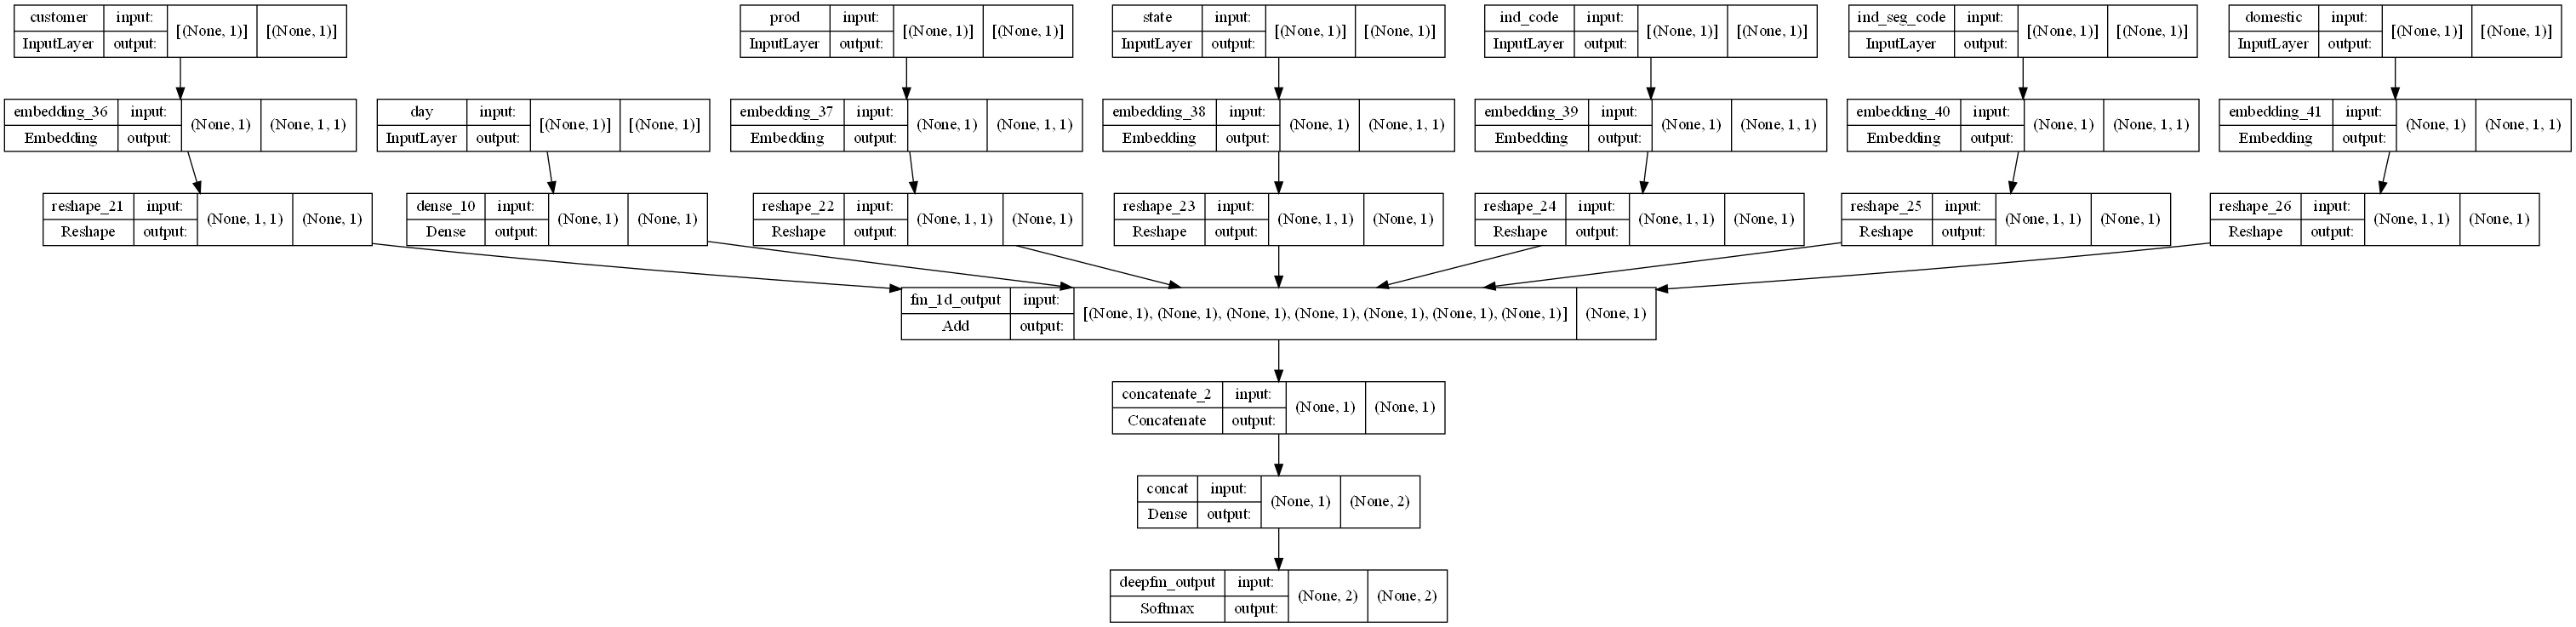

In [36]:
def mf_model():
    inputs = define_input_layers(transformed)
    y_fm_1d = fm_1d(inputs)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    mf_model = Model(inputs, y)
    return mf_model

MF = mf_model()
plot_model(MF, show_shapes=True, show_layer_names=True)

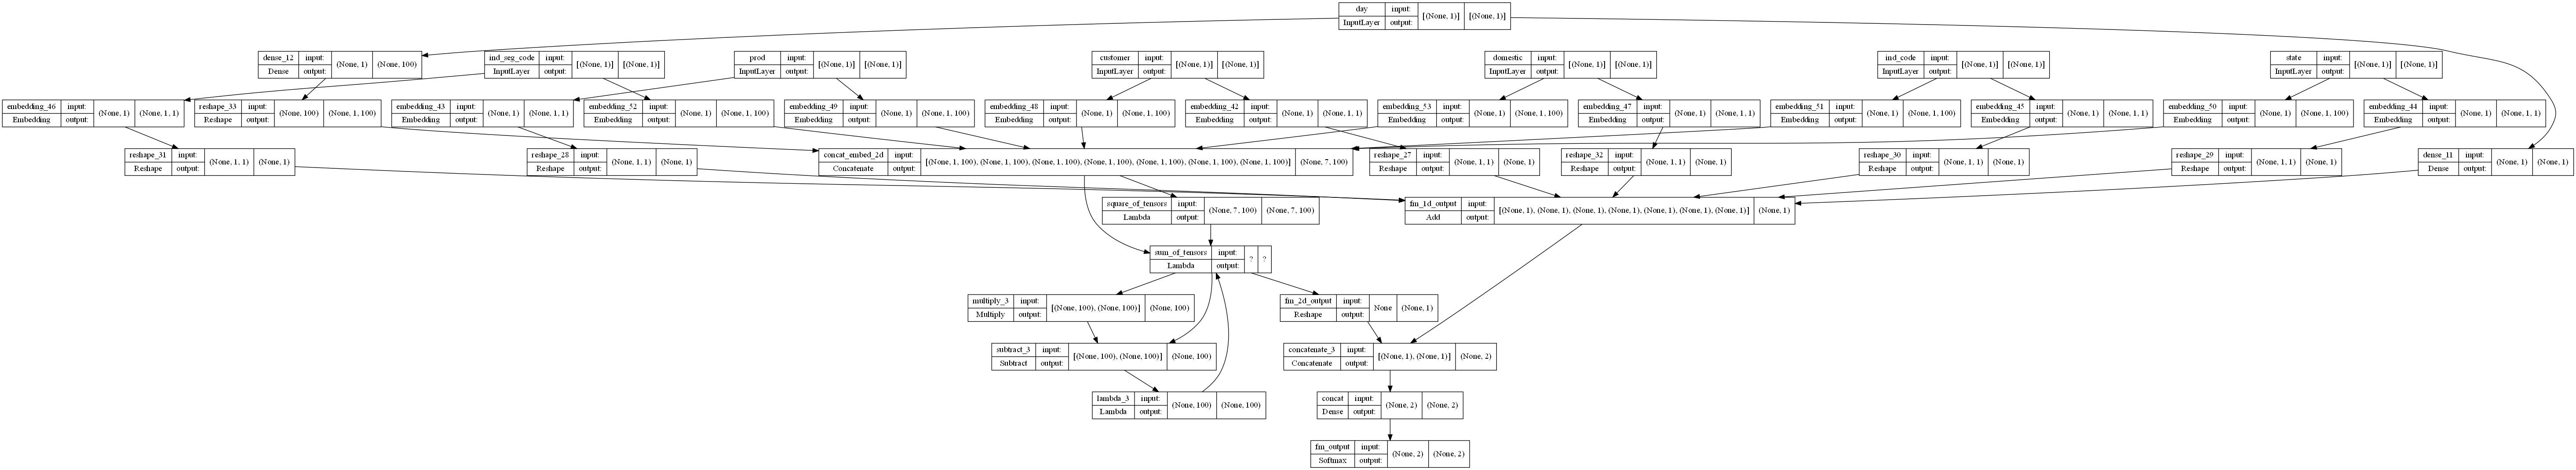

In [37]:
FM_params = {
    'k':100
}

def fm_model(k):
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'fm_output')(y)
    FM_model = Model(inputs, y)
    
    return FM_model, embed_2d
FM, _ = fm_model(**FM_params)
plot_model(FM, show_shapes=True, show_layer_names=True)

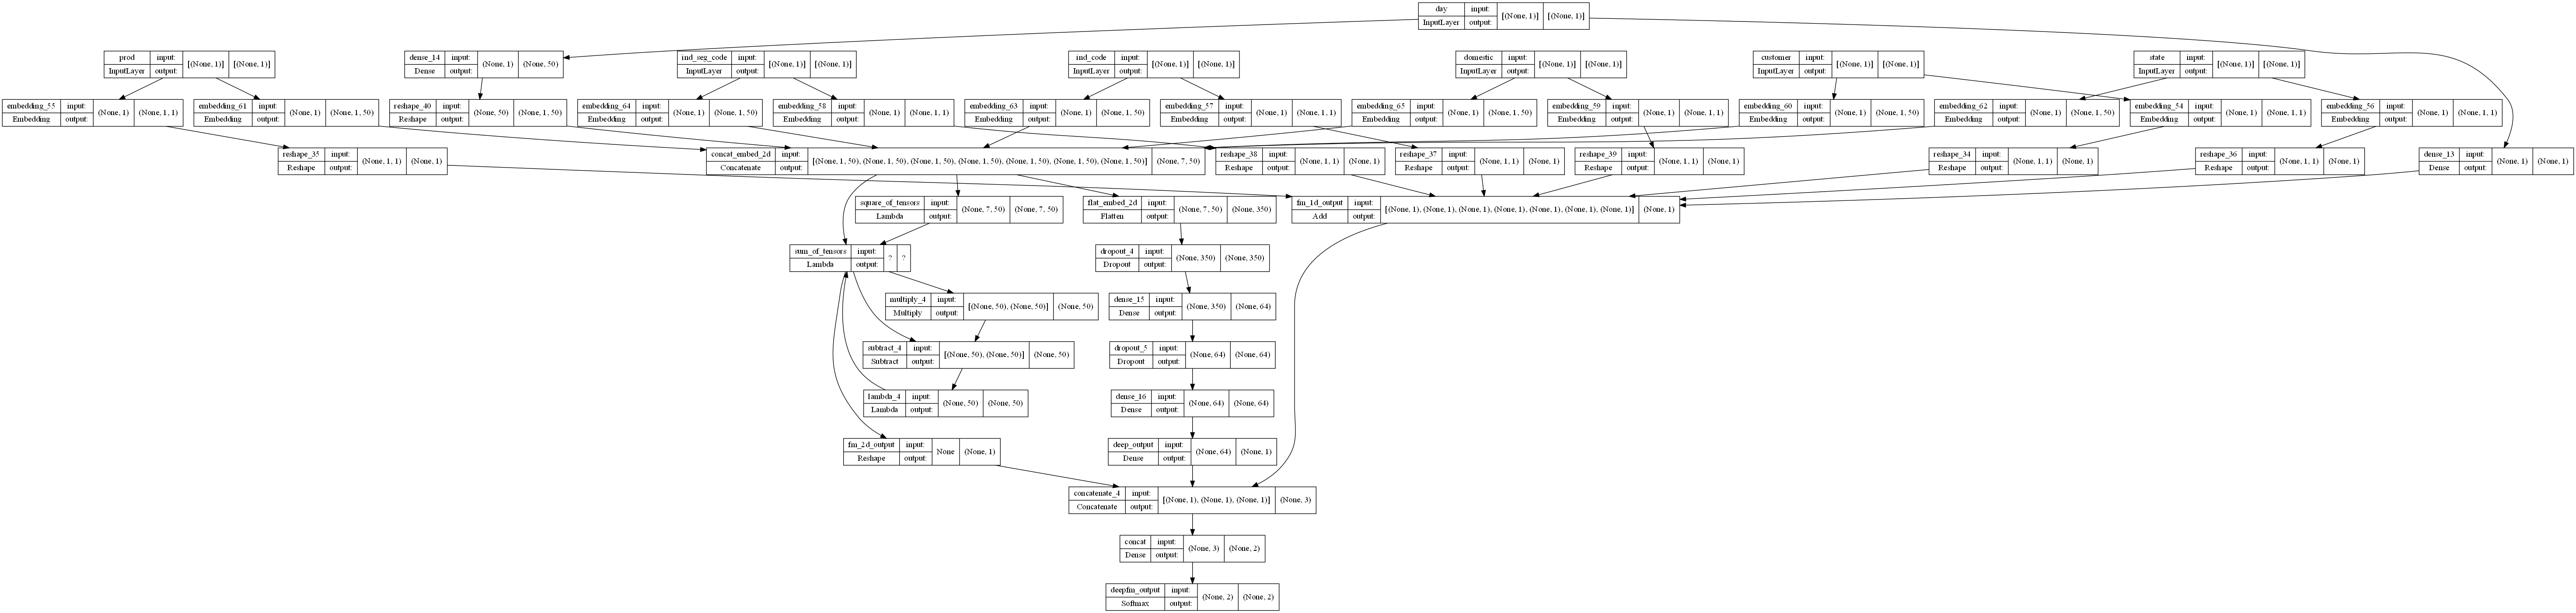

In [38]:
deepFM_params = {
    'k':50,
    'dnn_dim':[64, 64],
    'dnn_dr': 0.2
}

def deep_fm_model(k, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu"):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = dnn_part(embed_2d, dnn_dim, dnn_dr, k_reg, a_reg, act_fun)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

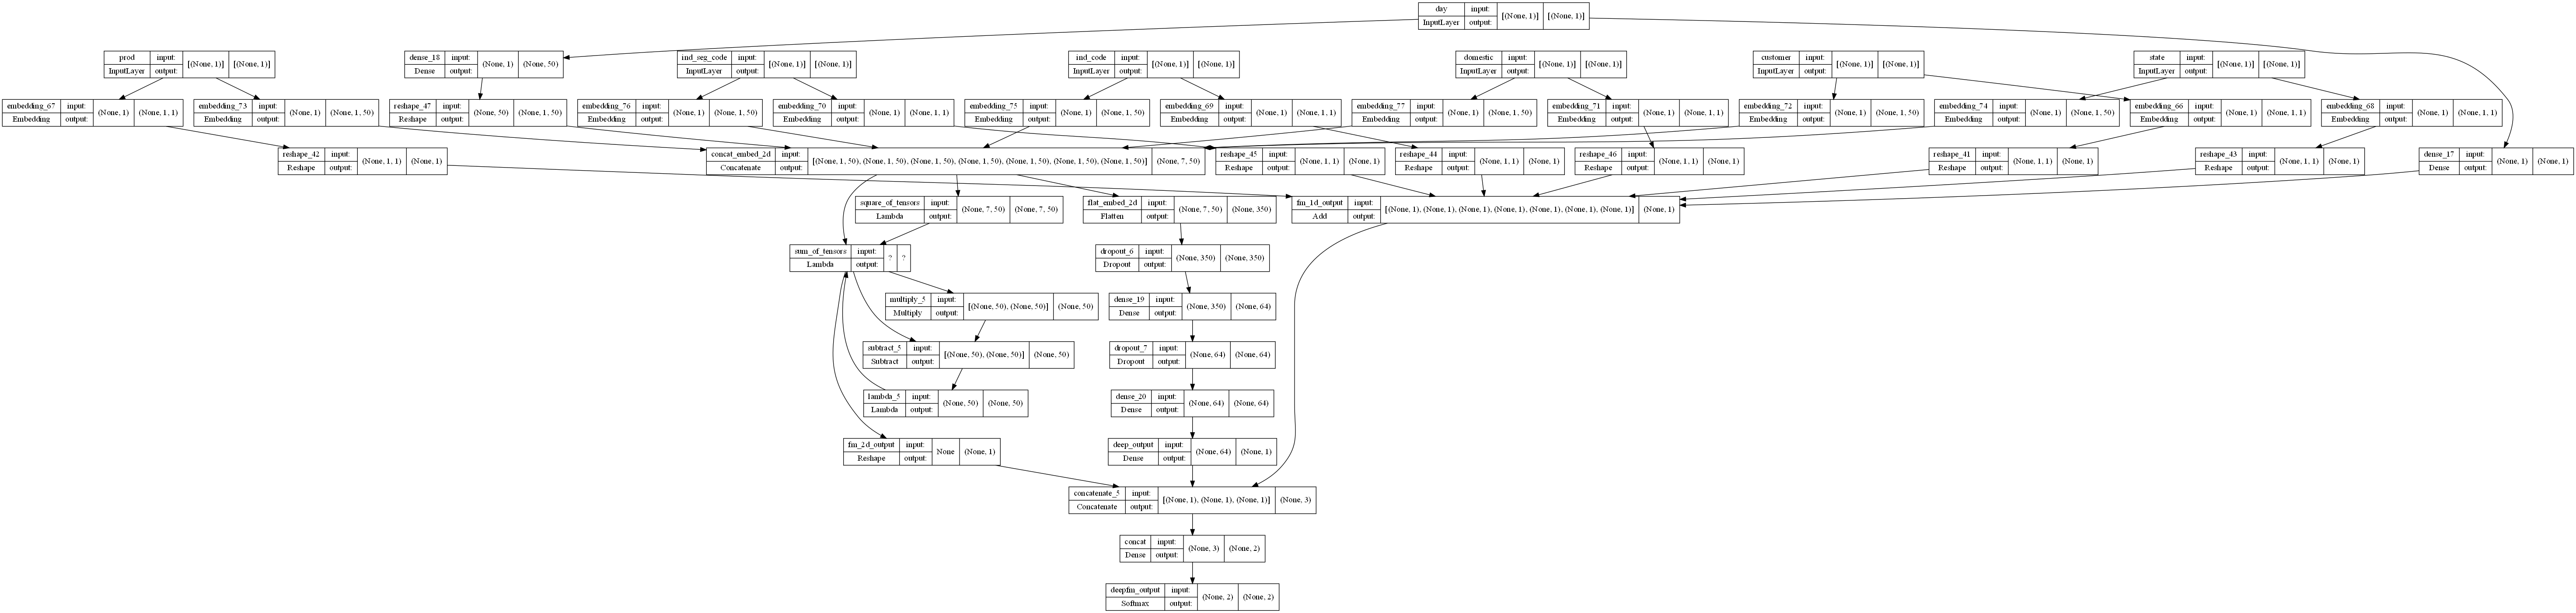

In [39]:
def lstm_fm_model(k, lstm_dim, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = lstm_part(embed_2d, lstm_dim=lstm_dim, dnn_dim=dnn_dim, dnn_dr=dnn_dr, k_reg=k_reg, a_reg=a_reg, act_fun=act_fun, lstm_fun=lstm_fun)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

## 2. Training

In [40]:
def df2xy(df, model):
    x = [df[inp.name].values for inp in model.inputs]
    y = df.label.values
    return x,np.asarray(y).astype('float32')

In [17]:
mf_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    tar = f'./models/1d_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/1d_{i}_{prod_class}_new_tunning.h5'
    train, test = transaction_tuple
    fm_model_1d = mf_model()
    train_x, train_y = df2xy(train, fm_model_1d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    fm_model_1d.compile(loss = 'mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=tar, 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    if not exists(tar):
        # Train on entire train set (using optimal hyperparameters)   
        train_history = fm_model_1d.fit(train_x, train_y, 
                                              epochs=100, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=False)
    mf_model_arr.append(fm_model_1d)
# fm_model_1d.load_weights(f"./models/1d_0_tunning.h5")

In [26]:
# DeepFM wrapper function
def run_fm(train_x, train_y, val_x, val_y, params):
    """
    Wrapper function for hyperparameter tunning.
    """
    fm_model_2d,_ = fm_model(k=params["k"])
            #train_x, train_y = df2xy(train, fm_model_1d)
            #train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    fm_model_2d.compile(loss = 'mse', optimizer=keras.optimizers.Adam(lr=params["lr"]))
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model_ckp = ModelCheckpoint(filepath=f'./models/2d_{i}_tunning.h5', 
                                                monitor='val_loss',
                                                save_weights_only=True, 
                                                save_best_only=True)
    callbacks = [early_stop, model_ckp]
            
    train_history = fm_model_2d.fit(train_x, train_y, 
                                                    epochs=300, batch_size=1024, 
                                                    #validation_split=0.1, 
                                                    callbacks = callbacks,
                                                    verbose=0,
                                                    validation_data=[val_x, val_y])
            
    return train_history, fm_model_2d

In [41]:
fm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    tar = f'./models/2d_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/2d_{i}_{prod_class}_new_tunning.h5'
    ptar = f'./params/2d_{i}_{prod_class}_tunning.csv' if not predict_only_new_products else f'./params/2d_{i}_{prod_class}_new_tunning.csv'
    train, test = transaction_tuple
    fm_model_2d, _ = fm_model(**FM_params)
    train_x, train_y = df2xy(train, fm_model_2d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    if not exists(tar):
        if not exists(ptar):
            # tune hyperparameters
            p = {
                "k": [20, 30, 50, 100],
                'dnn_dim':[[64, 64]],
                "lr": [1e-5, 1e-4, 5e-4, 1e-3],
                "dropout": [0.1, 0.2, 0.3],
                "l1": [0, 1e-4, 1e-3, 1e-2],
                "l2": [0, 1e-4, 1e-3, 1e-2],
                "activation_function": ["tanh", "relu", "sigmoid"]}
            parallel_gpu_jobs(6)
            scan_object = talos.Scan(train_x, train_y, model=run_fm, params=p, experiment_name="FM", multi_input=True,
                         fraction_limit=.01)
        
            scan_object.data.to_csv(ptar, index=False)
            
        early_stop = EarlyStopping(monitor='val_loss', patience=20)
        model_ckp = ModelCheckpoint(filepath=tar, 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
        callbacks = [early_stop, model_ckp]
        
        fm_model_2d.compile(loss = 'mse', optimizer='adam')
        
        train_history = fm_model_2d.fit(train_x, train_y,
                                              epochs=1000, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose = False)
    fm_model_arr.append(fm_model_2d)
# fm_model_2d.load_weights('./models/2d_0_tunning.h5')

In [ ]:
# DeepFM wrapper function
def run_deepfm(train_x, train_y, val_x, val_y, params):
    """
    Wrapper function for hyperparameter tunning.
    """
    deepfm_model = deep_fm_model(k=params["k"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
    #train_x, train_y = df2xy(train, fm_model_1d)
    #train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    # split a single job to multiple GPUs
    deepfm_model = multi_gpu(deepfm_model)
    deepfm_model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(lr=params["lr"]))
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model_ckp = ModelCheckpoint(filepath=f'./models/deepfm_{i}_tunning.h5', 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    train_history = deepfm_model.fit(train_x, train_y, 
                                              epochs=300, batch_size=1024, 
                                              #validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=0,
                                              validation_data=[val_x, val_y])
    
    return train_history, deepfm_model

In [ ]:
deepfm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    tar = f'./models/deepfm_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/deepfm_{i}_{prod_class}_new_tunning.h5'
    ptar = f'./params/deepfm_{i}_{prod_class}_tunning.csv' if not predict_only_new_products else f'./params/deepfm_{i}_{prod_class}_new_tunning.csv'
    train, test = transaction_tuple
    deepfm_model = deep_fm_model(**deepFM_params)
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    if not exists(tar):
        if not exists(ptar):
            # tune hyperparameters
            p = {
                "k": [20, 30, 50, 100],
                'dnn_dim':[[64, 64]],
                "lr": [1e-5, 1e-4, 5e-4, 1e-3],
                "dropout": [0.1, 0.2, 0.3],
                "l1": [0, 1e-4, 1e-3, 1e-2],
                "l2": [0, 1e-4, 1e-3, 1e-2],
                "activation_function": ["tanh", "relu", "sigmoid"]}
            parallel_gpu_jobs(6)
            scan_object = talos.Scan(train_x, train_y, model=run_deepfm, params=p, experiment_name="DeepFM", multi_input=True,
                         fraction_limit=.01)
        
            scan_object.data.to_csv(ptar, index=False)
        
    scan_params = pd.read_csv(ptar)
    params = scan_params.sort_values("loss").head(1).apply(lambda x: literal_eval(x) if (type(x) == str) else x).to_dict('records')[0]
    params["dnn_dim"] = literal_eval(params["dnn_dim"])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    model_ckp = ModelCheckpoint(filepath=tar, 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
        
    # read hyperparameters
    deepfm_model = deep_fm_model(k=params["k"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()

    deepfm_model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(lr=params["lr"]))
        
    # train with optimal hyperparameters
    train_history = deepfm_model.fit(train_x, train_y, 
                                              epochs=1000, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose = False)
    deepfm_model_arr.append(deepfm_model)
# deepfm_model.load_weights(f'./models/deepfm_0_tunning.h5')

In [ ]:
# DeepFM wrapper function
def run_lstmfm(train_x, train_y, val_x, val_y, params):
    """
    Wrapper function for hyperparameter tunning.
    """
    lstmfm_model = lstm_fm_model(k=params["k"], lstm_dim=params["lstm_dim"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
    #train_x, train_y = df2xy(train, fm_model_1d)
    #train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    # split a single job to multiple GPUs
    lstmfm_model = multi_gpu(lstmfm_model)
    lstmfm_model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=params["lr"]))
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    model_ckp = ModelCheckpoint(filepath=f'./models/lstmfm_{i}_tunning.h5', 
                                        monitor='val_loss',
                                        save_weights_only=True, 
                                        save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    train_history = lstmfm_model.fit(train_x, train_y, 
                                              epochs=300, batch_size=1024, 
                                              #validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=0,
                                              validation_data=[val_x, val_y])
    
    return train_history, lstmfm_model

In [ ]:
lstmfm_model_arr = []

lstmFM_params = {
    'k':100,
    'lstm_dim': [64],
    'dnn_dim':[64, 64],
    'dnn_dr': 0.3
}

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    tar = f'./models/lstmfm_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/lstmfm_{i}_{prod_class}_new_tunning.h5'
    ptar = f'./params/lstmfm_{i}_{prod_class}_tunning.csv' if not predict_only_new_products else f'./params/lstmfm_{i}_{prod_class}_new_tunning.csv'
    train, test = transaction_tuple
    lstmfm_model = lstm_fm_model(**lstmFM_params)
    train_x, train_y = df2xy(train, lstmfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    
    if not exists(tar):
        if not exists(ptar):
            # tune hyperparameters
            p = {
                "k": [20, 30, 50, 100],
                'lstm_dim': [[64]],
                'dnn_dim':[[64, 64]],
                "lr": [1e-5, 1e-4, 5e-4, 1e-3, 1e-2],
                "dropout": [0.1, 0.2, 0.3],
                "l1": [0, 1e-4, 1e-3, 1e-2],
                "l2": [0, 1e-4, 1e-3, 1e-2],
                "activation_function": ["tanh", "relu", "sigmoid"]}
            parallel_gpu_jobs(6)
            scan_object = talos.Scan(train_x, train_y, model=run_lstmfm, params=p, experiment_name="LstmFM", multi_input=True,
                         fraction_limit=.01)
        
            scan_object.data.to_csv(ptar, index=False)
        
    scan_params = pd.read_csv(ptar)
    params = scan_params.sort_values("loss").head(1).apply(lambda x: literal_eval(x) if (type(x) == str) else x).to_dict('records')[0]
    params["dnn_dim"] = literal_eval(params["dnn_dim"])
    params["lstm_dim"] = literal_eval(params["lstm_dim"])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    model_ckp = ModelCheckpoint(filepath=tar, 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
        
    # read hyperparameters
    lstmfm_model = lstm_fm_model(k=params["k"], lstm_dim=params["lstm_dim"], dnn_dim=params["dnn_dim"], dnn_dr=params["dropout"], 
                                k_reg=(params["l1"], params["l2"]), a_reg=(params["l1"], params["l2"]), act_fun=params["activation_function"])
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()

    lstmfm_model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(lr=params["lr"]))
        
    # train with optimal hyperparameters
    train_history = lstmfm_model.fit(train_x, train_y, 
                                              epochs=1000, batch_size=1024, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose = False)
    lstmfm_model_arr.append(lstmfm_model)
# deepfm_model.load_weights(f'./models/deepfm_0_tunning.h5')

## 3. Evaluation

### 3.1 Score (for top k products)

In [42]:
eval_models = [("1d", mf_model_arr), ("2d", fm_model_arr)]
eval_k = [1, 2, 3, 5, 10, 15, 20, 30]
hit_eval = pd.DataFrame(columns=["algorithm", "k", "fold", "hit_rate"])
train_prod = set(train["prod"]) 
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            print(f"Scoring iteration k: {k}, {i}", end="\r")
            train, test = transaction_tuple
            test = test[test["prod"].apply(lambda x: x in train_prod)] # keep only products present in train (compatibility reasons)
            if predict_only_new_products:
                bought_prod = {customer: set(train[train.customer == customer]["prod"].unique()) for customer in train.customer.unique()}
                test = test[~test.apply(lambda row: row["prod"] in bought_prod[row["customer"]], axis=1)]
            model_name, model_arr = model_tuple
            model = model_arr[i]
            tar = f'./models/{model_name}_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/{model_name}_{i}_{prod_class}_new_tunning.h5'
            model.load_weights(tar)
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_deepfm = test.copy()
            pred_deepfm["score"] = model.predict(test_x,
                                        batch_size=1024)[:, 1]
            eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
            # print(f"Hit@{k} score {model_name} (CV-{i}): {ana.label.mean()}")
            hit_eval = hit_eval.append({"algorithm": model_name, 
                             "k": k,
                             "fold": i,
                             "hit_rate": ana.label.mean()}, ignore_index=True)
        # print("------------------------------------------------------------------------------------------------")
hit_tar = f'./models/hit_rate_cv_folds_{prod_class}_tunning.csv' if not predict_only_new_products else f'./models/hit_rate_cv_folds_{prod_class}_new_tunning.csv'
hit_eval.to_csv(hit_tar, index=False)
hit_rate = hit_eval.groupby(["algorithm", "k"]).mean().reset_index().drop(["fold"], axis=1).sort_values(["k", "algorithm"])
hit_tar2 = f'./models/hit_rate_{prod_class}_tunning.csv' if not predict_only_new_products else f'./models/hit_rate_{prod_class}_new_tunning.csv'
hit_rate.to_csv(hit_tar2, index=False)
hit_rate

,algorithm,k,hit_rate
0,1d,1,0.070175
8,2d,1,0.000000
1,1d,2,0.333333
9,2d,2,0.000000
2,1d,3,0.456140
10,2d,3,0.000000
3,1d,5,0.508772
11,2d,5,0.000000
4,1d,10,0.596491
12,2d,10,0.070175


In [ ]:
# pred_deepfm[["day", "customer", "prod", "label", "score"]].sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5).sort_values(["customer", "score"])

### 3.2 F1-Score (for values above threshold)

In [ ]:
eval_models = [("1d", mf_model_arr), ("2d", fm_model_arr), ("deepfm", deepfm_model_arr), ("lstmfm", lstmfm_model_arr)]
eval_k = [10, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
thresholds = [0.1 * i for i in range(1,10)]
f1_res = pd.DataFrame(columns=["k", "threshold", "f1"])
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            test = test[test["prod"].apply(lambda x: x in train_prod)] # keep only products present in train (compatibility reasons)
            if predict_only_new_products:
                bought_prod = {customer: set(train[train.customer == customer]["prod"].unique()) for customer in train.customer.unique()}
                test = test[~test.apply(lambda row: row["prod"] in bought_prod[row["customer"]], axis=1)]
            model_name, model_arr = model_tuple
            model = model_arr[i]
            tar = f'./models/{model_name}_{i}_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/{model_name}_{i}_{prod_class}_new_tunning.h5'
            model.load_weights(tar)
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_model = test.copy()
            pred_model["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            eval_model = pred_model.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            # threshold
            for t in thresholds:
                print(f"F1-scoring iteration: k: {k}, t: {round(t, 1)}, model: {model_name}", end="\r")
                eval_model["above_thresh"] = eval_model.score > t # mark those above and bellow threshold (POSITIVE)
                eval_model["TP"] = eval_model["above_thresh"] & (eval_model.label == 1)
                eval_model["FN"] = ~eval_model["above_thresh"] & (eval_model.label == 1)
                TP = np.array(eval_model[["day", "customer", "TP"]].groupby(["day", "customer"]).sum().reset_index()["TP"]).sum()
                FN = np.array(eval_model[["day", "customer", "FN"]].groupby(["day", "customer"]).sum().reset_index()["FN"]).sum()
                P = np.array(eval_model[["day", "customer", "above_thresh"]].groupby(["day", "customer"]).sum().reset_index()["above_thresh"]).sum()
                not_sure_what = len(eval_model[(eval_model.label == 1)]["prod"].unique()) # len(test[(test.label == 1)]["prod"].unique())
                #print(TP)
                #print(P)
                #print(FN)
                precision = 0 if P == 0 else TP / P
                recall = TP / test[test.label == 1][["customer", "prod"]].groupby("customer").nunique()["prod"].sum()
                # recall = TP / not_sure_what
                # print(f"Precision: {precision}")
                # print(f"Recall: {recall}")
                # print(f"F1-score: {2 * (precision * recall) / (precision + recall)}")
                f1_res = f1_res.append({
                    "k": k,
                    "algorithm": model_name,
                    "threshold": t,
                    "f1": 2 * (precision * recall) / (precision + recall)
                }, ignore_index=True)
                # calculate recall
                # ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
                # print(f"Hit@{k} F1-score {model_name} (CV-{i}, threshold: {t}): {ana.label.mean()}")
    print("------------------------------------------------------------------------------------------------")
hit_tar = f'./models/f1_cv_folds_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/f1_cv_folds_{prod_class}_new_tunning.h5'
f1_res.to_csv(hit_tar, index=False)
f1_plt = f1_res.groupby(["algorithm", "threshold"]).mean().reset_index()
f1_plt["std"] = f1_res.groupby(["algorithm", "threshold"]).std().reset_index().f1
hit_tar2 = f'./models/f1_{prod_class}_tunning.h5' if not predict_only_new_products else f'./models/f1_{prod_class}_new_tunning.h5'
f1_plt.to_csv(hit_tar2, index=False)
hit_rate

In [ ]:
f1_plt

In [ ]:
fig, ax = plt.subplots(1, 1)
my_k = [10]
for k in my_k:
    for i, model_tuple in zip(range(len(eval_models)), eval_models):
        model_name, model = model_tuple
        print(model_name)
        bol = (f1_plt.algorithm == model_name)
        # ax.plot(f1_plt[bol]["threshold"], f1_plt[bol]["f1"], label=f"{model_name}")
        ax.errorbar(f1_plt[bol]["threshold"], f1_plt[bol]["f1"], yerr=f1_plt[bol]["std"], uplims=False, lolims=False,
             label=model_name, capsize=5, capthick=1)
        ax.legend()
        # ax[0].axis('square')
        # ax.set_ylim(0.0, 0.6)
        ax.set_xlim(0.0, 0.9)
        ax.set_xlabel("threshold")
        ax.set_ylabel("F1 score")
        ax.grid()
plt.show()